<a href="https://colab.research.google.com/github/younghoonNa/PyTorch/blob/main/Pytorch/Pytorch_5_Perceptron_ReLU_Weight_initializaion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [32]:
import torch.nn as nn
import torch 
import torch.optim as optim

import random

# how to solve vanishing Gradient
- Change activation function -> ReLU() ,
- Optimizer -> Adam(), SGD() ...ect
- Careful initialization -> normal_ -> xavier / He initializaion
- Dropout
- Small learning rate
- Batch Normalizaion

# Perceptron 1 

- perceptron으로 XoR 문제를 해결하지 못함.
  - why : singlelayer perceptron 이기 때문

In [33]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# for reproducibility
random.seed(42)
torch.manual_seed(42)
if device == 'cuda':
    torch.cuda.manual_seed_all(42)

In [34]:
#XOR Gate

X = torch.Tensor([[0,0], [0,1], [1,0], [1,1]]) 
Y = torch.Tensor([[0], [1] , [1], [0]])

#perceptron은 1개의 layer를 가짐.
linear = nn.Linear(2,1, bias = True)  #bias -> H(x) = Wx + b 에서 b = bias
sigmoid = nn.Sigmoid() #activation func = sigmoid

model = nn.Sequential(linear, sigmoid).to(device)  # 모델은 1개의 층을 가짐. linear, ac_func = sigmoid

criterion = nn.BCELoss().to(device) #0과1을 분류 하는 binary classificaion 이기 때문에 Binary Cross Entropy Loss 사용
optimizer = optim.SGD(model.parameters(), lr=1) 

for step in range(10001):
  optimizer.zero_grad()
  hypothesis = model(X)

  cost = criterion(hypothesis, Y)
  cost.backward()
  optimizer.step()

  if step%1000 == 0:
    print(step, cost.item())

0 0.7317379713058472
1000 0.6931471824645996
2000 0.6931471824645996
3000 0.6931471824645996
4000 0.6931471824645996
5000 0.6931471824645996
6000 0.6931471824645996
7000 0.6931471824645996
8000 0.6931471824645996
9000 0.6931471824645996
10000 0.6931471824645996


-> 학습이 제대로 되지 않음.

In [35]:
# Accuracy computation
# True if hypothesis>0.5 else False
with torch.no_grad():
    hypothesis = model(X)
    predicted = (hypothesis > 0.5).float()
    accuracy = (predicted == Y).float().mean()
    print('\nHypothesis: ', hypothesis.detach().cpu().numpy(), '\nCorrect: ', predicted.detach().cpu().numpy(), '\nAccuracy: ', accuracy.item())


Hypothesis:  [[0.5]
 [0.5]
 [0.5]
 [0.5]] 
Correct:  [[0.]
 [0.]
 [0.]
 [0.]] 
Accuracy:  0.5


# Perceptron 2 

- Multilayer Perceptron 을 사용하여 Xor 문제를 해결해보자 - (Marvin Minsky)
- Backpropagation
  - Loss (정답과 입력값의 차이) & Neural Network의 Weight 값


## $ \quad \frac {∂Loss}{∂Weight} ➢ Loss 값을 최소화시킬 수 있도록 weight값을 설정. $

- Perceptron 1과 유사한 Xor Gate

In [36]:
#XOR Gate

X = torch.Tensor([[0,0], [0,1], [1,0], [1,1]]).to(device)
Y = torch.Tensor([[0], [1] , [1], [0]]).to(device)

w1 = torch.Tensor(2,2).to(device)
b1 = torch.Tensor(2).to(device)
w2 = torch.Tensor(2,1).to(device)
b2 = torch.Tensor(1).to(device)

def sigmoid(x):
  return 1.0/(1.0 + torch.exp(-x))

def sigmoid_prime(x):
  return sigmoid(x) * (1-sigmoid(x))

learning_rate = 1

for step in range(10001):
  
  #forward 단계
  l1 = torch.add(torch.matmul(X, w1), b1)
  a1 = sigmoid(l1)
  l2 = torch.add(torch.matmul(a1, w2), b2)
  Y_pred = sigmoid(l2)

  cost = -torch.mean(Y * torch.log(Y_pred) + (1 - Y) * torch.log(1-Y_pred))#BCELoss

  #입력값에 대해 Loss 구하고 backpropagation 준비.
    # cost.backward()
  d_Y_pred = (Y_pred - Y) / (Y_pred * (1.0 - Y_pred) + 1e-7) # 예측값과 실제 값 차이에 대한 미분

  #layer 2에 대한 backpropagation
  d_l2 = d_Y_pred * sigmoid_prime(l2)
  d_b2 = d_l2
  d_w2 = torch.matmul(torch.transpose(a1, 0, 1), d_b2)

  #layer 1에 대한 backpropagation
  d_a1 = torch.matmul(d_b2, torch.transpose(w2, 0,1))
  d_l1 = d_a1 * sigmoid_prime(l1)
  d_b1 = d_l1
  d_w1 = torch.matmul(torch.transpose(X, 0, 1), d_b1)


  # optimizer.step()
  w1 = w1 - learning_rate * d_w1
  b1 = b1 - learning_rate * torch.mean(d_b1, 0)
  w2 = w2 - learning_rate * d_w2
  b2 = b2 - learning_rate * torch.mean(d_b2, 0)


  if step%1000 == 0:
    print(step, cost.item())

0 0.6931471824645996
1000 0.6931471824645996
2000 0.6931471824645996
3000 0.6931471824645996
4000 0.6931471824645996
5000 0.6931471824645996
6000 0.6931471824645996
7000 0.6931471824645996
8000 0.6931471824645996
9000 0.6931471824645996
10000 0.6931471824645996


In [37]:
X = torch.Tensor([[0,0], [0,1], [1,0], [1,1]]).to(device)
Y = torch.Tensor([[0], [1] , [1], [0]]).to(device)

linear1 = nn.Linear(2,2, bias = True)
linear2 = nn.Linear(2,1, bias = True)
sigmoid = nn.Sigmoid()

model = nn.Sequential(
    linear1, sigmoid,
     linear2, sigmoid
     ).to(device)

criterion = nn.BCELoss().to(device)
optimizer = optim.SGD(model.parameters(), lr = 1)

for step in range(10001):
  optimizer.zero_grad()
  hypothesis = model(X)

  cost = criterion(hypothesis, Y)
  cost.backward()
  optimizer.step()

  if step % 1000 == 0:
    print(step, cost.item())

0 0.6969633102416992
1000 0.01702870801091194
2000 0.006113256793469191
3000 0.0036975739058107138
4000 0.002644683700054884
5000 0.002056611469015479
6000 0.0016816440038383007
7000 0.0014218575088307261
8000 0.001231352798640728
9000 0.0010857279412448406
10000 0.0009707921417430043


In [38]:
# Accuracy computation
# True if hypothesis>0.5 else False
with torch.no_grad():
    hypothesis = model(X)
    predicted = (hypothesis > 0.5).float()
    accuracy = (predicted == Y).float().mean()
    print('\nHypothesis: ', hypothesis.detach().cpu().numpy(), '\nCorrect: ', predicted.detach().cpu().numpy(), '\nAccuracy: ', accuracy.item())


Hypothesis:  [[9.2718127e-04]
 [9.9871850e-01]
 [9.9913567e-01]
 [8.0776797e-04]] 
Correct:  [[0.]
 [1.]
 [1.]
 [0.]] 
Accuracy:  1.0


# Perceptron 3

- Multilayer Perceptron
  - 조금 더 층이 많은 모델을 만들어보자

In [39]:
X = torch.FloatTensor([[0,0], [0,1], [1,0], [1,1]]).to(device)
Y = torch.FloatTensor([[0], [1], [1], [0]]).to(device)

linear1 = nn.Linear(2,10, bias = True)
linear2 = nn.Linear(10,10, bias =True)
linear3 = nn.Linear(10,10, bias = True)
linear4 = nn.Linear(10,1, bias = True)
sigmoid = nn.Sigmoid()


model = nn.Sequential(
    linear1, sigmoid,
     linear2, sigmoid,
     linear3, sigmoid,
     linear4, sigmoid
     ).to(device)

criterion = nn.BCELoss().to(device)
optimizer = optim.SGD(model.parameters(), lr = 1)

for step in range(10001):
  optimizer.zero_grad()
  hypothesis = model(X)

  cost = criterion(hypothesis, Y)
  cost.backward()
  optimizer.step()

  if step % 1000 == 0:
    print(step, cost.item())

0 0.6995851993560791
1000 0.6931251287460327
2000 0.6931029558181763
3000 0.6930482387542725
4000 0.6927956938743591
5000 0.6060340404510498
6000 0.0012026206823065877
7000 0.0005025514401495457
8000 0.00031129003036767244
9000 0.00022355785768013448
10000 0.00017359902267344296


In [40]:
# Accuracy computation
# True if hypothesis>0.5 else False
with torch.no_grad():
    hypothesis = model(X)
    predicted = (hypothesis > 0.5).float()
    accuracy = (predicted == Y).float().mean()
    print('\nHypothesis: ', hypothesis.detach().cpu().numpy(), '\nCorrect: ', predicted.detach().cpu().numpy(), '\nAccuracy: ', accuracy.item())


Hypothesis:  [[1.3108492e-04]
 [9.9981195e-01]
 [9.9982435e-01]
 [1.9942237e-04]] 
Correct:  [[0.]
 [1.]
 [1.]
 [0.]] 
Accuracy:  1.0


# Relu

- Problem of sigmoid : `Vanishing Gradient`
- Relu
- Optimizer in pytorch

In [63]:
import torchvision.datasets as dsets
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt

In [64]:
mnist_train = dsets.MNIST(root = './', train = True, 
                          transform = transforms.ToTensor(), download=True)

mnist_test = dsets.MNIST(root='./', train = False, 
                        transform = transforms.ToTensor(), download=True)

In [57]:
batch_size = 100
learning_rate = 0.001
training_epochs = 15

In [53]:
# dataset loader
data_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

In [70]:
linear1 = nn.Linear(784, 256, bias = True).to(device)
linear2 = nn.Linear(256, 256, bias = True).to(device)
linear3 = nn.Linear(256, 10, bias = True).to(device)
relu = nn.ReLU()

# input = 28*28, output = 0-9 , 
nn.init.normal_(linear1.weight)
nn.init.normal_(linear2.weight)
nn.init.normal_(linear3.weight)

model = nn.Sequential(
    linear1, relu,
    linear2, relu,
    linear3).to(device)

    #3번째는 relu 말고 CEL 쓸거라서 활성함수 없음.

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters() , lr = learning_rate)

In [72]:
total_batch = len(data_loader)

for epoch in range(training_epochs):

  avg_cost = 0

  for X, Y in data_loader:
    X = X.view(-1, 28*28).to(device)
    Y = Y.to(device)

    optimizer.zero_grad()
    hypothesis = model(X)
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()

    avg_cost += cost / total_batch
  
  print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 147.064178467
Epoch: 0002 cost = 34.907199860
Epoch: 0003 cost = 21.782573700
Epoch: 0004 cost = 15.006265640
Epoch: 0005 cost = 10.807533264
Epoch: 0006 cost = 7.973686218
Epoch: 0007 cost = 5.931622028
Epoch: 0008 cost = 4.573240757
Epoch: 0009 cost = 3.307158709
Epoch: 0010 cost = 2.526352882
Epoch: 0011 cost = 1.852702260
Epoch: 0012 cost = 1.408059478
Epoch: 0013 cost = 1.120530605
Epoch: 0014 cost = 0.896840513
Epoch: 0015 cost = 0.761476517
Learning finished


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9458000063896179
Label:  4
Prediction:  4


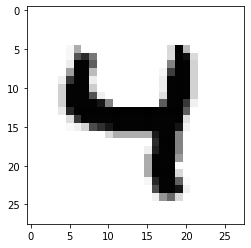

In [74]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()

# Weight Initalization

- RBM : Restricted Boltzmann Machine
  - 같은 Layer 끼리는 연결 X
  - 다른 Layer 끼리는 Fully Connected

# Xavier / He initialization

## Xavier
- Normal 

`W ~ N (0, Var(W)) ` =  $ \quad Var(W) = \sqrt { \frac{2}{n_{in} + n_{out}} } $

- Uniform

W ~ U * $ \quad ( - \sqrt { \frac{6}{n_{in} + n_{out}} } + \sqrt { \frac{6}{n_{in} + n_{out}} } $ )

## He initialization

- He Normal initialization
### $ \quad Var(W) = \sqrt { \frac {2}{n_{in}}} $

- He Uniform initialization
### W ~ U * $ \quad ( - \sqrt { \frac{6}{n_{in}} } + \sqrt { \frac{6}{n_{in}} } $ )


In [76]:
# 위의 내용을 함수로 나타내면
def xavier_uniform_(tensor, gain =1):
  fan_in, fan_out = _calculate_fan_in_end_fan_out(tensor)
  std = gain * math.sqrt(2.0 / (fan_in + fan_out))
  a = math.sqrt(3.0) * std

  with torch.no_grad():
    return tensor.uniform_(-a,a)

In [77]:
linear1 = nn.Linear(784, 256, bias = True).to(device)
linear2 = nn.Linear(256, 256, bias = True).to(device)
linear3 = nn.Linear(256, 10, bias = True).to(device)
relu = nn.ReLU()

# input = 28*28, output = 0-9 , 

# 초기화 함수를 normal_ -> xavier_uniform_으로 바꿨을 때.
nn.init.xavier_uniform_(linear1.weight)
nn.init.xavier_uniform_(linear2.weight)
nn.init.xavier_uniform_(linear3.weight)

model = nn.Sequential(
    linear1, relu,
    linear2, relu,
    linear3).to(device)

    #3번째는 relu 말고 CEL 쓸거라서 활성함수 없음.

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters() , lr = learning_rate)

In [78]:
total_batch = len(data_loader)

for epoch in range(training_epochs):

  avg_cost = 0

  for X, Y in data_loader:
    X = X.view(-1, 28*28).to(device)
    Y = Y.to(device)

    optimizer.zero_grad()
    hypothesis = model(X)
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()

    avg_cost += cost / total_batch
  
  print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.244254008
Epoch: 0002 cost = 0.093738005
Epoch: 0003 cost = 0.060548943
Epoch: 0004 cost = 0.044325326
Epoch: 0005 cost = 0.031223107
Epoch: 0006 cost = 0.025237601
Epoch: 0007 cost = 0.021070525
Epoch: 0008 cost = 0.018055074
Epoch: 0009 cost = 0.017774364
Epoch: 0010 cost = 0.013228278
Epoch: 0011 cost = 0.012610132
Epoch: 0012 cost = 0.012641924
Epoch: 0013 cost = 0.011620486
Epoch: 0014 cost = 0.009771386
Epoch: 0015 cost = 0.008543672
Learning finished


Accuracy: 0.9811999797821045
Label:  9
Prediction:  9


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


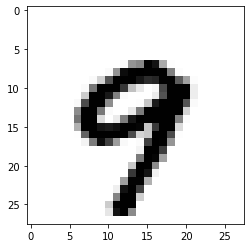

In [79]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()

# 좀 더 layer가 많은 모델로 가보자

In [80]:
linear1 = nn.Linear(784, 512, bias = True).to(device)
linear2 = nn.Linear(512, 512, bias = True).to(device)
linear3 = nn.Linear(512, 512, bias = True).to(device)
linear4 = nn.Linear(512, 512, bias = True).to(device)
linear5 = nn.Linear(512, 10, bias = True).to(device)
relu = nn.ReLU()

# input = 28*28, output = 0-9 , 

# 초기화 함수를 normal_ -> xavier_uniform_으로 바꿨을 때.
nn.init.xavier_uniform_(linear1.weight)
nn.init.xavier_uniform_(linear2.weight)
nn.init.xavier_uniform_(linear3.weight)
nn.init.xavier_uniform_(linear4.weight)
nn.init.xavier_uniform_(linear5.weight)


model = nn.Sequential(
    linear1, relu,
    linear2, relu,
    linear3, relu,
    linear4, relu,
    linear5).to(device)

    #5번째는 relu 말고 CEL 쓸거라서 활성함수 없음.

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters() , lr = learning_rate)

In [81]:
total_batch = len(data_loader)

for epoch in range(training_epochs):

  avg_cost = 0

  for X, Y in data_loader:
    X = X.view(-1, 28*28).to(device)
    Y = Y.to(device)

    optimizer.zero_grad()
    hypothesis = model(X)
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()

    avg_cost += cost / total_batch
  
  print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.218855426
Epoch: 0002 cost = 0.089012124
Epoch: 0003 cost = 0.063692339
Epoch: 0004 cost = 0.047330040
Epoch: 0005 cost = 0.039833356
Epoch: 0006 cost = 0.032477669
Epoch: 0007 cost = 0.029213179
Epoch: 0008 cost = 0.028004643
Epoch: 0009 cost = 0.022532273
Epoch: 0010 cost = 0.019642722
Epoch: 0011 cost = 0.017105510
Epoch: 0012 cost = 0.018372765
Epoch: 0013 cost = 0.017823776
Epoch: 0014 cost = 0.017481146
Epoch: 0015 cost = 0.013713071
Learning finished


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.9799000024795532
Label:  1
Prediction:  1


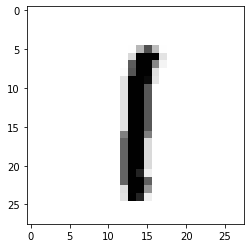

In [82]:
with torch.no_grad():
    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()

# DropOut

- overfitting
- DropOut
- `model.train()` , `model.eval()`
  - `model.train()` 을 선언 후 학습하게 되면 Dropout = True 상태로 진행
    - 모델 `학습` 때 사용
  - `model.eval()` 을 선언 후 학습하게 되면 Dropout = False 상태로 진행
    - 모델 `검증` 때 사용 (오차 계산)
  - 위의 두 명령을 가지고 Dropout 사용 여부를 결정 가능함.
  - `BatchNormalization` 에서도 사용

In [84]:
drop_prob = 0.1

In [85]:
linear1 = nn.Linear(784, 512, bias = True).to(device)
linear2 = nn.Linear(512, 512, bias = True).to(device)
linear3 = nn.Linear(512, 512, bias = True).to(device)
linear4 = nn.Linear(512, 512, bias = True).to(device)
linear5 = nn.Linear(512, 10, bias = True).to(device)
relu = nn.ReLU()
dropout = nn.Dropout(p=drop_prob)

# input = 28*28, output = 0-9 , 

# 초기화 함수를 normal_ -> xavier_uniform_으로 바꿨을 때.
nn.init.xavier_uniform_(linear1.weight)
nn.init.xavier_uniform_(linear2.weight)
nn.init.xavier_uniform_(linear3.weight)
nn.init.xavier_uniform_(linear4.weight)
nn.init.xavier_uniform_(linear5.weight)


model = nn.Sequential(
    linear1, relu, dropout,
    linear2, relu, dropout,
    linear3, relu, dropout,
    linear4, relu, dropout,
    linear5).to(device)

    #5번째는 relu 말고 CEL 쓸거라서 활성함수 없음.

criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters() , lr = learning_rate)

In [86]:
total_batch = len(data_loader)
model.train()

for epoch in range(training_epochs):

  avg_cost = 0

  for X, Y in data_loader:
    X = X.view(-1, 28*28).to(device)
    Y = Y.to(device)

    optimizer.zero_grad()
    hypothesis = model(X)
    cost = criterion(hypothesis, Y)
    cost.backward()
    optimizer.step()

    avg_cost += cost / total_batch
  
  print('Epoch:', '%04d' % (epoch + 1), 'cost =', '{:.9f}'.format(avg_cost))

print('Learning finished')

Epoch: 0001 cost = 0.236883253
Epoch: 0002 cost = 0.102075197
Epoch: 0003 cost = 0.074885376
Epoch: 0004 cost = 0.062215909
Epoch: 0005 cost = 0.051216461
Epoch: 0006 cost = 0.044434432
Epoch: 0007 cost = 0.039290726
Epoch: 0008 cost = 0.036600884
Epoch: 0009 cost = 0.032409642
Epoch: 0010 cost = 0.029187528
Epoch: 0011 cost = 0.027894884
Epoch: 0012 cost = 0.026690256
Epoch: 0013 cost = 0.023532705
Epoch: 0014 cost = 0.024523210
Epoch: 0015 cost = 0.021590304
Learning finished


/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:67: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")
/usr/local/lib/python3.7/dist-packages/torchvision/datasets/mnist.py:57: UserWarning: test_labels has been renamed targets
  warnings.warn("test_labels has been renamed targets")


Accuracy: 0.980400025844574
Label:  1
Prediction:  1


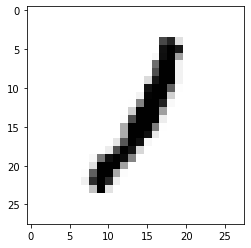

In [87]:
with torch.no_grad():
    model.eval()

    X_test = mnist_test.test_data.view(-1, 28 * 28).float().to(device)
    Y_test = mnist_test.test_labels.to(device)

    prediction = model(X_test)
    correct_prediction = torch.argmax(prediction, 1) == Y_test
    accuracy = correct_prediction.float().mean()
    print('Accuracy:', accuracy.item())

    # Get one and predict
    r = random.randint(0, len(mnist_test) - 1)
    X_single_data = mnist_test.test_data[r:r + 1].view(-1, 28 * 28).float().to(device)
    Y_single_data = mnist_test.test_labels[r:r + 1].to(device)

    print('Label: ', Y_single_data.item())
    single_prediction = model(X_single_data)
    print('Prediction: ', torch.argmax(single_prediction, 1).item())

    plt.imshow(mnist_test.test_data[r:r + 1].view(28, 28), cmap='Greys', interpolation='nearest')
    plt.show()

# Batch Normalization 

- Interal Covariate Shift
  - Layer를 통과 할 때 마다 Train set의 분포가 달라짐.

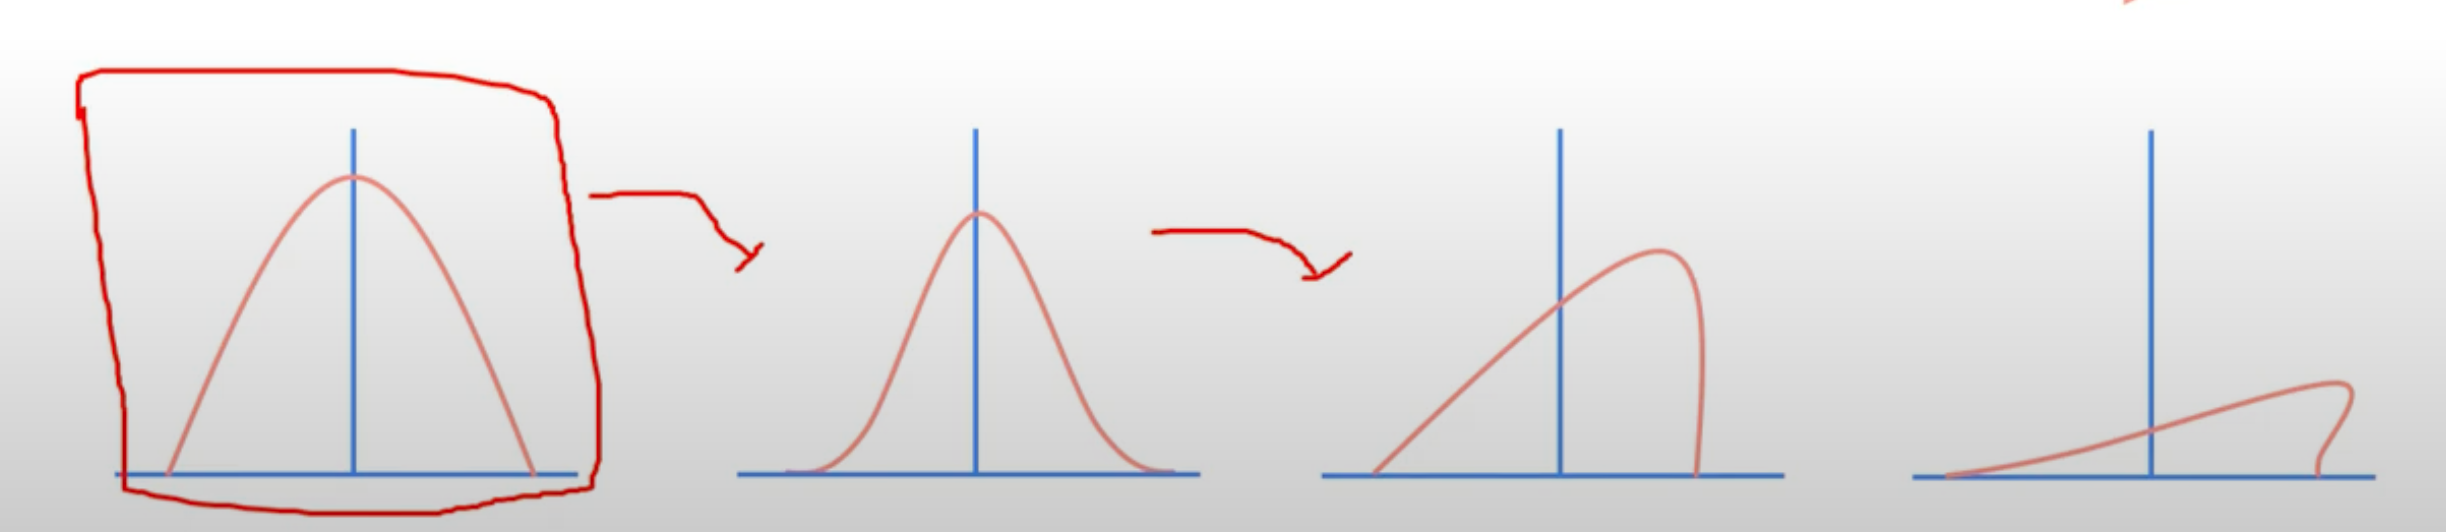

Layer 마다 Normalizaion을 해줌.

In [88]:
# dataset loader
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,
                                          batch_size=batch_size,
                                          shuffle=True,
                                          drop_last=True)

test_loader = torch.utils.data.DataLoader(dataset=mnist_test,
                                          batch_size=batch_size,
                                          shuffle=False,
                                          drop_last=True)

In [90]:
linear1 = nn.Linear(784, 32, bias = True).to(device)
linear2 = nn.Linear(32, 32, bias = True).to(device)
linear3 = nn.Linear(32, 10, bias = True).to(device)
relu = nn.ReLU()
dropout = nn.Dropout(p=drop_prob)
bn1 = nn.BatchNorm1d(32)
bn2 = nn.BatchNorm1d(32)


nn_linear1 = nn.Linear(784, 32, bias = True).to(device)
nn_linear2 = nn.Linear(32, 32, bias = True).to(device)
nn_linear3 = nn.Linear(32, 10, bias = True).to(device)

# input = 28*28, output = 0-9 , 

# 초기화 함수를 normal_ -> xavier_uniform_으로 바꿨을 때.
# nn.init.xavier_uniform_(linear1.weight)
# nn.init.xavier_uniform_(linear2.weight)
# nn.init.xavier_uniform_(linear3.weight)


bn_model = nn.Sequential(
    linear1, bn1, relu, dropout,
    linear2, bn2, relu, dropout,
    linear3).to(device)

nn_model = nn.Sequential(
    linear1, relu, dropout,
    linear2, relu, dropout,
    linear3).to(device)

    #3번째는 relu 말고 CEL 쓸거라서 활성함수 없음.

# define cost/loss & optimizer
criterion = torch.nn.CrossEntropyLoss().to(device)    # Softmax is internally computed.
bn_optimizer = torch.optim.Adam(bn_model.parameters(), lr=learning_rate)
nn_optimizer = torch.optim.Adam(nn_model.parameters(), lr=learning_rate)

In [91]:
# Save Losses and Accuracies every epoch
# We are going to plot them later
train_losses = []
train_accs = []

valid_losses = []
valid_accs = []

train_total_batch = len(train_loader)
test_total_batch = len(test_loader)
for epoch in range(training_epochs):
    bn_model.train()  # set the model to train mode

    for X, Y in train_loader:
        # reshape input image into [batch_size by 784]
        # label is not one-hot encoded
        X = X.view(-1, 28 * 28).to(device)
        Y = Y.to(device)

        bn_optimizer.zero_grad()
        bn_prediction = bn_model(X)
        bn_loss = criterion(bn_prediction, Y)
        bn_loss.backward()
        bn_optimizer.step()

        nn_optimizer.zero_grad()
        nn_prediction = nn_model(X)
        nn_loss = criterion(nn_prediction, Y)
        nn_loss.backward()
        nn_optimizer.step()

    with torch.no_grad():
        bn_model.eval()     # set the model to evaluation mode

        # Test the model using train sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(train_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / train_total_batch, nn_loss / train_total_batch, bn_acc / train_total_batch, nn_acc / train_total_batch

        # Save train losses/acc
        train_losses.append([bn_loss, nn_loss])
        train_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-TRAIN] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
            (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        # Test the model using test sets
        bn_loss, nn_loss, bn_acc, nn_acc = 0, 0, 0, 0
        for i, (X, Y) in enumerate(test_loader):
            X = X.view(-1, 28 * 28).to(device)
            Y = Y.to(device)

            bn_prediction = bn_model(X)
            bn_correct_prediction = torch.argmax(bn_prediction, 1) == Y
            bn_loss += criterion(bn_prediction, Y)
            bn_acc += bn_correct_prediction.float().mean()

            nn_prediction = nn_model(X)
            nn_correct_prediction = torch.argmax(nn_prediction, 1) == Y
            nn_loss += criterion(nn_prediction, Y)
            nn_acc += nn_correct_prediction.float().mean()

        bn_loss, nn_loss, bn_acc, nn_acc = bn_loss / test_total_batch, nn_loss / test_total_batch, bn_acc / test_total_batch, nn_acc / test_total_batch

        # Save valid losses/acc
        valid_losses.append([bn_loss, nn_loss])
        valid_accs.append([bn_acc, nn_acc])
        print(
            '[Epoch %d-VALID] Batchnorm Loss(Acc): bn_loss:%.5f(bn_acc:%.2f) vs No Batchnorm Loss(Acc): nn_loss:%.5f(nn_acc:%.2f)' % (
                (epoch + 1), bn_loss.item(), bn_acc.item(), nn_loss.item(), nn_acc.item()))
        print()

print('Learning finished')

[Epoch 1-TRAIN] Batchnorm Loss(Acc): bn_loss:0.20668(bn_acc:0.94) vs No Batchnorm Loss(Acc): nn_loss:0.19927(nn_acc:0.94)
[Epoch 1-VALID] Batchnorm Loss(Acc): bn_loss:0.20744(bn_acc:0.94) vs No Batchnorm Loss(Acc): nn_loss:0.20237(nn_acc:0.94)

[Epoch 2-TRAIN] Batchnorm Loss(Acc): bn_loss:0.14068(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.14168(nn_acc:0.96)
[Epoch 2-VALID] Batchnorm Loss(Acc): bn_loss:0.14979(bn_acc:0.95) vs No Batchnorm Loss(Acc): nn_loss:0.15146(nn_acc:0.95)

[Epoch 3-TRAIN] Batchnorm Loss(Acc): bn_loss:0.11788(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.11921(nn_acc:0.96)
[Epoch 3-VALID] Batchnorm Loss(Acc): bn_loss:0.13260(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.13663(nn_acc:0.96)

[Epoch 4-TRAIN] Batchnorm Loss(Acc): bn_loss:0.09505(bn_acc:0.97) vs No Batchnorm Loss(Acc): nn_loss:0.09341(nn_acc:0.97)
[Epoch 4-VALID] Batchnorm Loss(Acc): bn_loss:0.11829(bn_acc:0.96) vs No Batchnorm Loss(Acc): nn_loss:0.11956(nn_acc:0.96)

[Epoch 5-TRAIN] Batc

In [92]:
def plot_compare(loss_list: list, ylim=None, title=None) -> None:
    bn = [i[0] for i in loss_list]
    nn = [i[1] for i in loss_list]

    plt.figure(figsize=(15, 10))
    plt.plot(bn, label='With BN')
    plt.plot(nn, label='Without BN')
    if ylim:
        plt.ylim(ylim)

    if title:
        plt.title(title)
    plt.legend()
    plt.grid('on')
    plt.show()

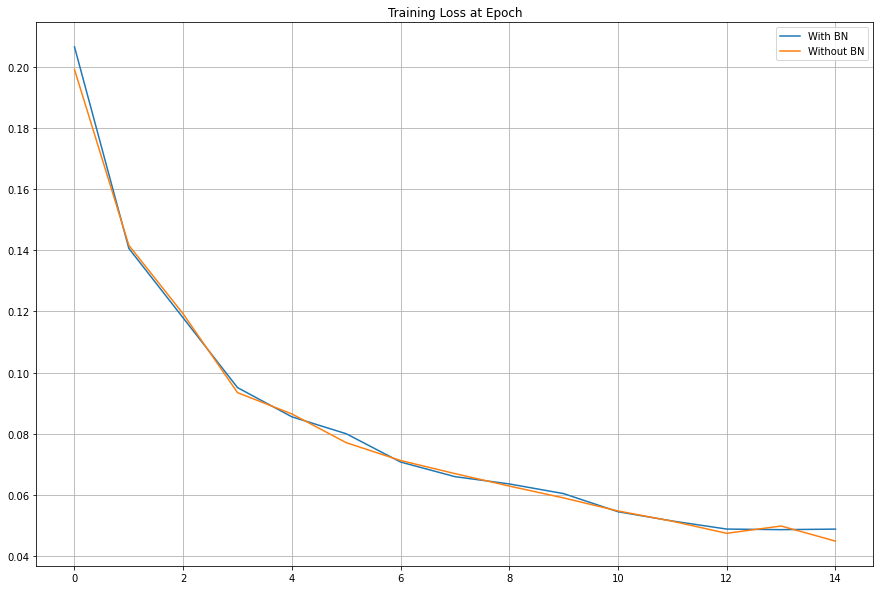

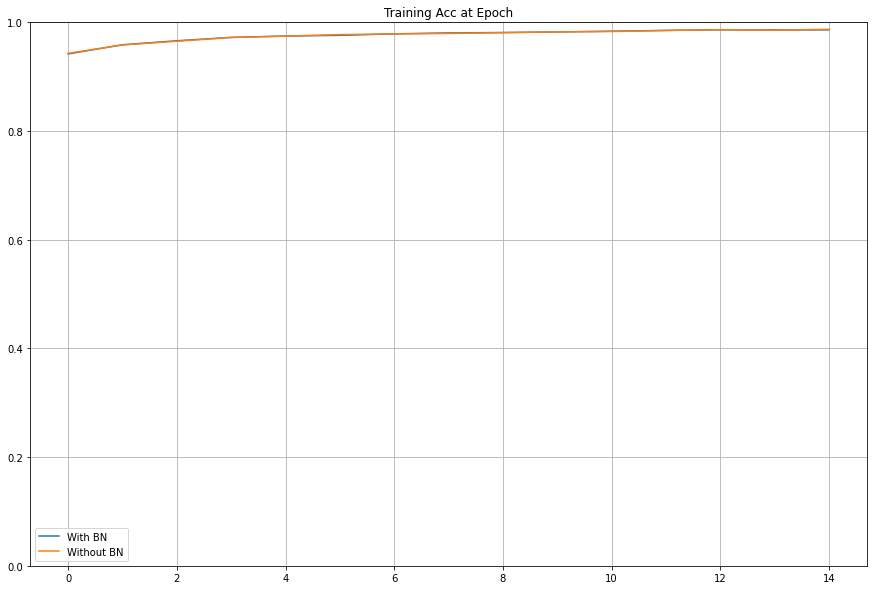

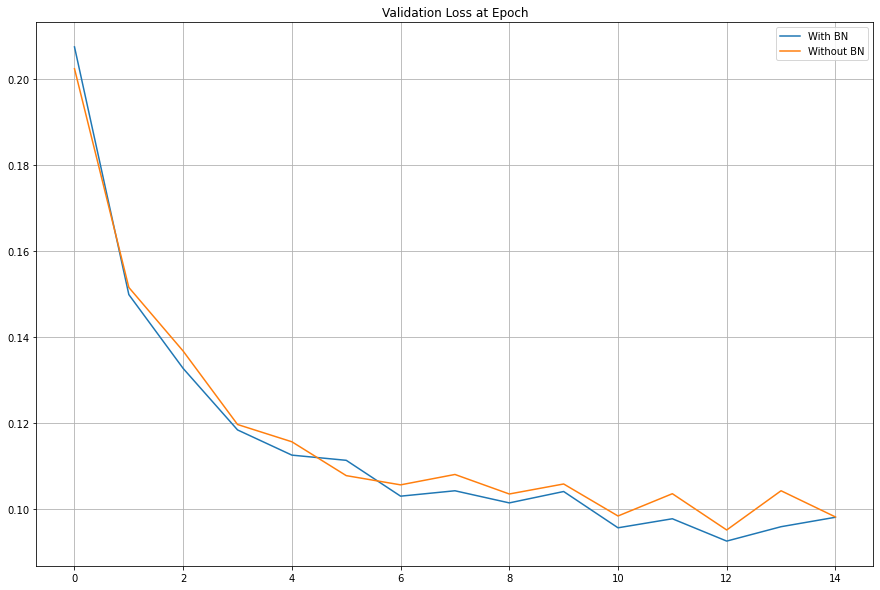

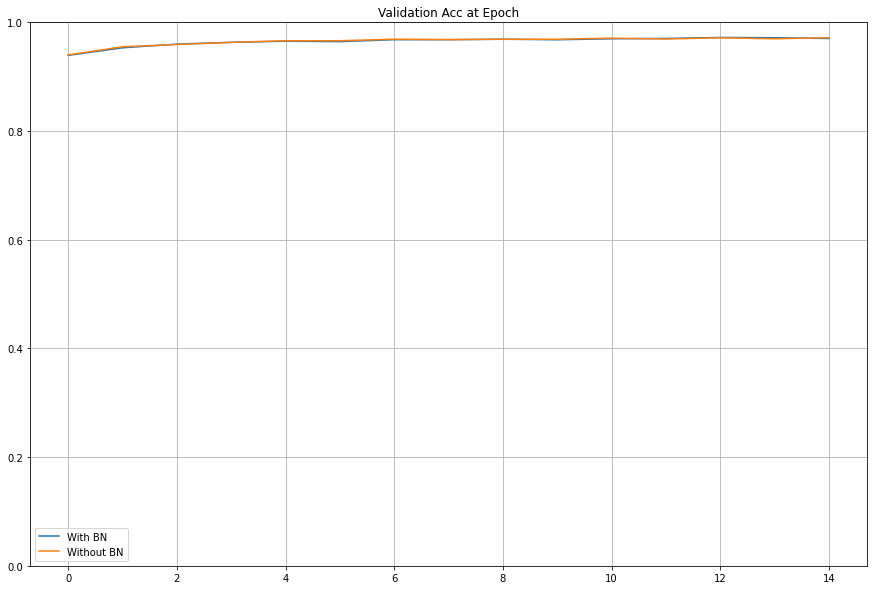

In [93]:
plot_compare(train_losses, title='Training Loss at Epoch')
plot_compare(train_accs, [0, 1.0], title='Training Acc at Epoch')
plot_compare(valid_losses, title='Validation Loss at Epoch')
plot_compare(valid_accs, [0, 1.0], title='Validation Acc at Epoch')